<a href="https://www.kaggle.com/code/dferhadi/travelers-insurance?scriptVersionId=93818146" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Travelers Insurance

In this notebook, we explore the dataset on kaggle: https://www.kaggle.com/datasets/mhdzahier/travel-insurance

We will do the following:

* Explore the dataset depicting insurance claims for travelers.
* Clean the data
* Make predictions about which travelers will submit claims.


Let's import the libraries we need for this notebook, I will be using matplotlib as well as seaborn to compare the two.

In [1]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score

import pickle

%matplotlib inline
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/travel-insurance/travel insurance.csv


In [2]:
import pandas as pd
import numpy as np
from plotly.offline import iplot, init_notebook_mode
import plotly.express as px
init_notebook_mode(connected=True)
import seaborn as sns
import matplotlib.pyplot as plt
from palettable.colorbrewer.qualitative import Pastel1_7
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score

In [3]:
#import data
df_travel=pd.read_csv('/kaggle/input/travel-insurance/travel insurance.csv')
df_travel.head()

,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Gender,Age
0,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,81
1,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,71
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,65,AUSTRALIA,-49.5,29.70,NaN,32
3,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,60,AUSTRALIA,-39.6,23.76,NaN,32
4,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,79,ITALY,-19.8,11.88,NaN,41


In [4]:
df_travel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63326 entries, 0 to 63325
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                63326 non-null  object 
 1   Agency Type           63326 non-null  object 
 2   Distribution Channel  63326 non-null  object 
 3   Product Name          63326 non-null  object 
 4   Claim                 63326 non-null  object 
 5   Duration              63326 non-null  int64  
 6   Destination           63326 non-null  object 
 7   Net Sales             63326 non-null  float64
 8   Commision (in value)  63326 non-null  float64
 9   Gender                18219 non-null  object 
 10  Age                   63326 non-null  int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 5.3+ MB


In [5]:
df_travel.shape

(63326, 11)

We can see from above that there are 63326 rows and 11 columns (4 numerical and 7 categorical). One variable (column) we are interested in is "Claim"

In [6]:
df_travel.columns

Index(['Agency', 'Agency Type', 'Distribution Channel', 'Product Name',
       'Claim', 'Duration', 'Destination', 'Net Sales', 'Commision (in value)',
       'Gender', 'Age'],
      dtype='object')

Let's remove the spaces in between some of the column names.

In [7]:
df_travel.rename(columns={ 'Agency Type':'Agency_Type', 'Distribution Channel':'Distribution_Channel', 'Product Name':'Product_Name','Net Sales':'Net_Sales', 'Commision (in value)':'Commision'},inplace=True)

In [8]:
df_travel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63326 entries, 0 to 63325
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                63326 non-null  object 
 1   Agency_Type           63326 non-null  object 
 2   Distribution_Channel  63326 non-null  object 
 3   Product_Name          63326 non-null  object 
 4   Claim                 63326 non-null  object 
 5   Duration              63326 non-null  int64  
 6   Destination           63326 non-null  object 
 7   Net_Sales             63326 non-null  float64
 8   Commision             63326 non-null  float64
 9   Gender                18219 non-null  object 
 10  Age                   63326 non-null  int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 5.3+ MB


Let's look for missing values.

In [9]:
df_travel.isnull().sum().any

<bound method NDFrame._add_numeric_operations.<locals>.any of Agency                      0
Agency_Type                 0
Distribution_Channel        0
Product_Name                0
Claim                       0
Duration                    0
Destination                 0
Net_Sales                   0
Commision                   0
Gender                  45107
Age                         0
dtype: int64>

There are a lot of missing values in the gender column so we will remove it.

In [10]:
df_travel=df_travel.drop(['Gender'], axis=1)
df_travel.head()

,Agency,Agency_Type,Distribution_Channel,Product_Name,Claim,Duration,Destination,Net_Sales,Commision,Age
0,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,81
1,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,71
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,65,AUSTRALIA,-49.5,29.70,32
3,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,60,AUSTRALIA,-39.6,23.76,32
4,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,79,ITALY,-19.8,11.88,41


To get a better feel for the data in each column, let's produce a list of unique values from each column...

In [11]:
column_keys=df_travel.select_dtypes(include=['object']).columns.tolist()
for key in column_keys:
    print('Unique values of',key,'are: ')
    print(df_travel[key].unique(),end='\n')
    print(end='\n')

Unique values of Agency are: 
['CBH' 'CWT' 'JZI' 'KML' 'EPX' 'C2B' 'JWT' 'RAB' 'SSI' 'ART' 'CSR' 'CCR'
 'ADM' 'LWC' 'TTW' 'TST']

Unique values of Agency_Type are: 
['Travel Agency' 'Airlines']

Unique values of Distribution_Channel are: 
['Offline' 'Online']

Unique values of Product_Name are: 
['Comprehensive Plan' 'Rental Vehicle Excess Insurance' 'Value Plan'
 'Basic Plan' 'Premier Plan' '2 way Comprehensive Plan' 'Bronze Plan'
 'Silver Plan' 'Annual Silver Plan' 'Cancellation Plan'
 '1 way Comprehensive Plan' 'Ticket Protector' '24 Protect' 'Gold Plan'
 'Annual Gold Plan' 'Single Trip Travel Protect Silver'
 'Individual Comprehensive Plan' 'Spouse or Parents Comprehensive Plan'
 'Annual Travel Protect Silver' 'Single Trip Travel Protect Platinum'
 'Annual Travel Protect Gold' 'Single Trip Travel Protect Gold'
 'Annual Travel Protect Platinum' 'Child Comprehensive Plan'
 'Travel Cruise Protect' 'Travel Cruise Protect Family']

Unique values of Claim are: 
['No' 'Yes']

Unique value

### Number of Claims

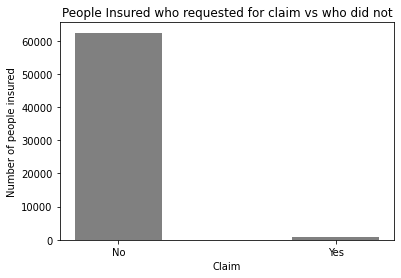

In [12]:
df_claims = df_travel.groupby(by=["Claim"]).size().reset_index(name="counts")
plt.bar(df_claims['Claim'], df_claims['counts'], color ='grey',width = 0.4)
plt.xlabel("Claim")
plt.ylabel("Number of people insured")
plt.title("People Insured who requested for claim vs who did not")
plt.show()

In [13]:
results = df_travel["Claim"].value_counts(dropna=False)
results

No     62399
Yes      927
Name: Claim, dtype: int64

In [14]:
print("Percentage of claims that are Yes: " , results[1]/(results[0] + results[1]))

Percentage of claims that are Yes:  0.014638537093768752


There are 927 individuals who requested claims, making up around 1.4% of all policy holders.

### Destinations

There seem to be a lot of destinations, let's see which are most popular...

In [15]:

df1 = df_travel.groupby(by=["Destination"]).size().reset_index(name="counts")
df1.nlargest(15,['counts'])
df1['DestinationNew'] = np.where(df1['counts']>1090, df1['Destination'], 'Others')
fig = px.pie(df1, values='counts', names='DestinationNew', title='Popular Destinations among insured')
fig.show()

### Age Distribution

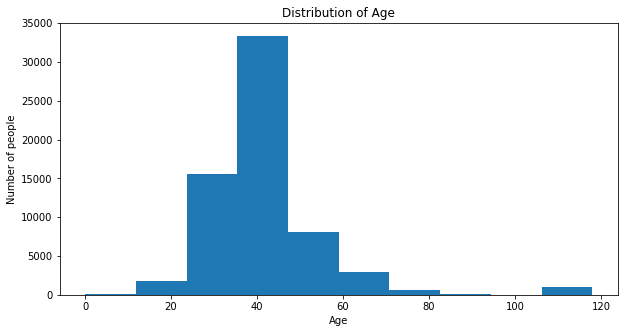

In [16]:
# histogram of age distribution
fig = plt.figure(figsize = (10, 5))
plt.hist(df_travel['Age'])
plt.xlabel("Age")
plt.ylabel("Number of people")
plt.title("Distribution of Age")
plt.show()

### Insurance Agencies

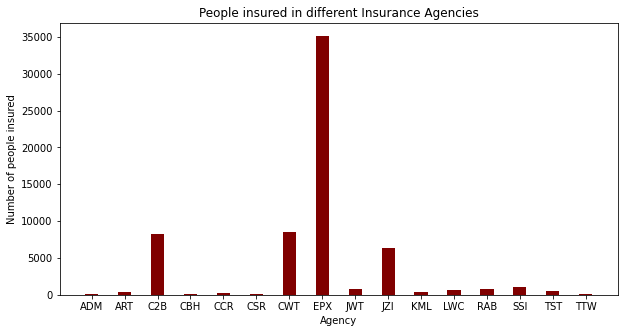

In [17]:
df2 = df_travel.groupby(by=["Agency"]).size().reset_index(name="counts")
fig = plt.figure(figsize = (10, 5))
plt.bar(df2['Agency'], df2['counts'], color ='maroon', width = 0.4)
plt.xlabel("Agency")
plt.ylabel("Number of people insured")
plt.title("People insured in different Insurance Agencies")
plt.show()

### Insurance Product Popularity

In [18]:
df1 = df_travel.groupby(by=["Product_Name"]).size().reset_index(name="counts")
df3 = df_travel.groupby(by=["Product_Name"]).size().reset_index(name="counts")
df3['Product_Name'] = np.where(df1['counts']>500, df1['Product_Name'], 'Others')
fig = px.pie(df3, values='counts', names='Product_Name', title='People insured under different plans')
fig.show()

The majority of people have selected the Cancellation Plan.

## Where are most claims coming from?

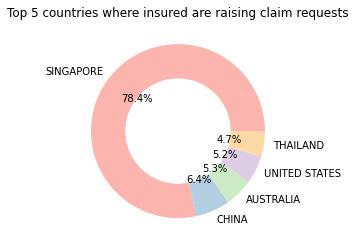

In [19]:
df5=df_travel.loc[df_travel['Claim']=='Yes']
df6= df5.groupby(by=["Destination"]).size().reset_index(name="counts")
df7=df6.nlargest(5,['counts'])
my_circle = plt.Circle((0, 0), 0.6, color='white')
plt.pie(df7['counts'], labels=df7['Destination'], autopct='%1.1f%%', colors=Pastel1_7.hex_colors)
plt.title('Top 5 countries where insured are raising claim requests')
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

The highest number of claims comes from Singapore, the number of claims from Singapore is around 4 times greater than that of all other countries combined.

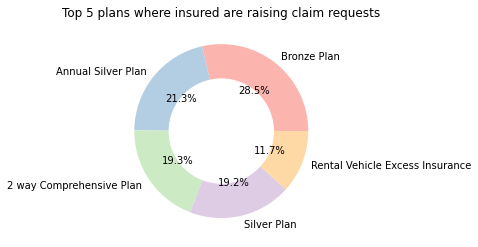

In [20]:
df8= df5.groupby(by=["Product_Name"]).size().reset_index(name="counts")
df9=df8.nlargest(5,['counts'])
my_circle = plt.Circle((0, 0), 0.6, color='white')
plt.pie(df9['counts'], labels=df9['Product_Name'], autopct='%1.1f%%',colors=Pastel1_7.hex_colors)
plt.title('Top 5 plans where insured are raising claim requests')
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

The Bronze and Annual Silver plans make up half of all claims.

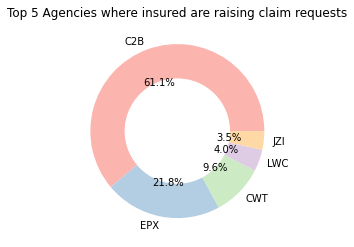

In [21]:
df10= df5.groupby(by=["Agency"]).size().reset_index(name="counts")
df11=df10.nlargest(5,['counts'])
my_circle = plt.Circle((0, 0), 0.6, color='white')
plt.pie(df11['counts'], labels=df11['Agency'], autopct='%1.1f%%', colors=Pastel1_7.hex_colors)
plt.title('Top 5 Agencies where insured are raising claim requests')
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

The overwhelming majority of claims is coming from two agencies, C2B and EPX, even more than all claims from Singapore.

### Let's check some features

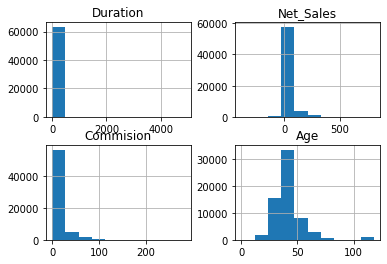

In [22]:
hist=df_travel.hist()

In [23]:
df_travel.describe()

,Duration,Net_Sales,Commision,Age
count,63326.000000,63326.000000,63326.000000,63326.000000
mean,49.317074,40.702018,9.809992,39.969981
std,101.791566,48.845637,19.804388,14.017010
min,-2.000000,-389.000000,0.000000,0.000000
25%,9.000000,18.000000,0.000000,35.000000
50%,22.000000,26.530000,0.000000,36.000000
75%,53.000000,48.000000,11.550000,43.000000
max,4881.000000,810.000000,283.500000,118.000000


### Duration of Trip

There are some negative values which need to be removed...

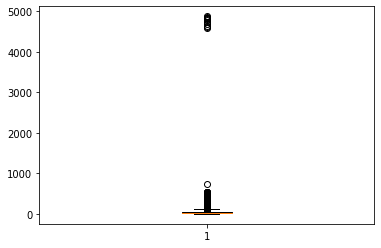

In [24]:
fig = plt.figure(figsize =(6,4 ))
plt.boxplot(df_travel['Duration'])
plt.show()

index_duration = df_travel[df_travel['Duration'] < 0 ].index
df_travel.drop(index_duration, inplace = True)

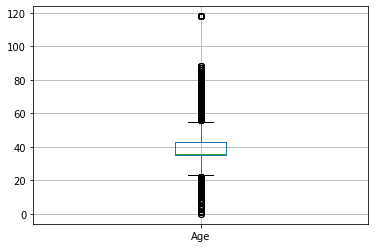

In [25]:
boxplot1 = df_travel.boxplot(column=['Age'])

Age looks okay, no negative values here. However 118 is a high age...

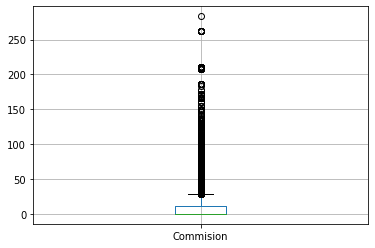

In [26]:
boxplot2 = df_travel.boxplot(column=['Commision'])

Seems like there is an issue with the highest value, around 280 seems unreasonable.

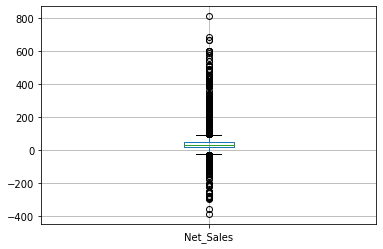

In [27]:
boxplot4 = df_travel.boxplot(column=['Net_Sales'])

We already got rid of the negative values.

In [28]:
df_travel["Agency"].value_counts(dropna=False)



EPX    35119
CWT     8580
C2B     8267
JZI     6324
SSI     1056
JWT      749
RAB      725
LWC      689
TST      528
KML      392
ART      331
CCR      194
CBH      101
TTW       98
CSR       86
ADM       82
Name: Agency, dtype: int64

In [29]:
df_travel["Agency_Type"].value_counts(dropna=False)

Travel Agency    45869
Airlines         17452
Name: Agency_Type, dtype: int64

In [30]:
df_travel["Distribution_Channel"].value_counts(dropna=False)

Online     62214
Offline     1107
Name: Distribution_Channel, dtype: int64

### Below we look for possible relationships between different features

Notice there seems to be a strong linear relationship between Net_Sales and Commission

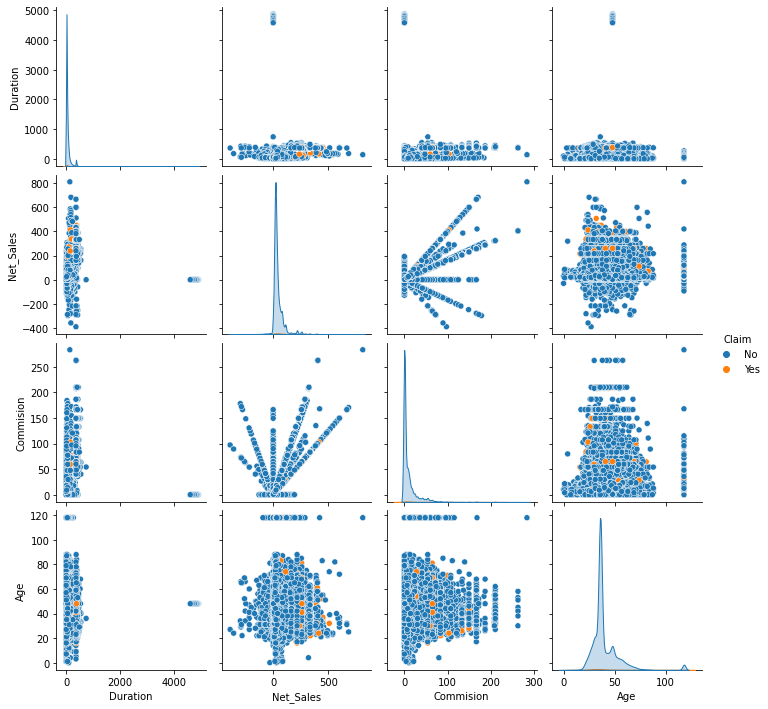

In [31]:
sns.pairplot(df_travel, hue="Claim")

### Correlation Map

<AxesSubplot:>

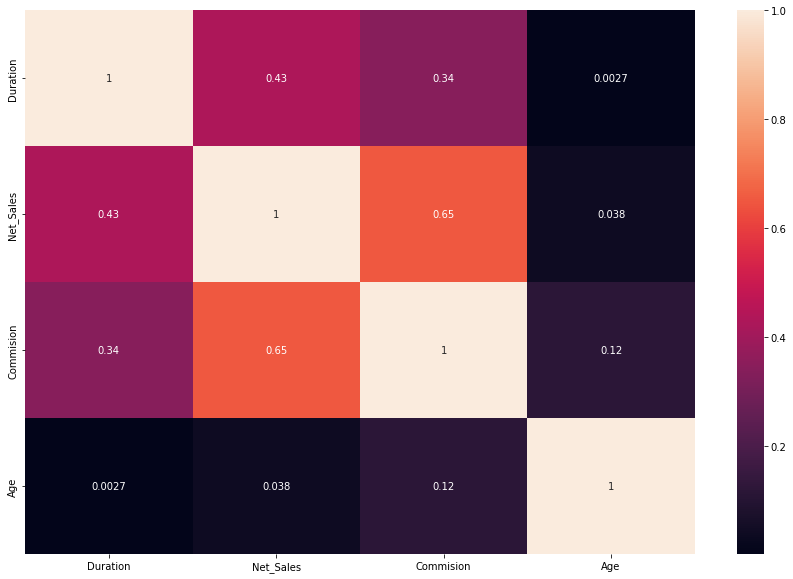

In [32]:

fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df_travel.corr(), annot=True, ax=ax)

# Predicting Claims using ML

### One-Hot Encoding for feature engineering

In [33]:
from sklearn import preprocessing
label_encoder1 = preprocessing.LabelEncoder()
df_travel['Agency']= label_encoder1.fit_transform(df_travel['Agency'])
  
label_encoder2 = preprocessing.LabelEncoder()
df_travel['Agency_Type']= label_encoder2.fit_transform(df_travel['Agency_Type'])

label_encoder3 = preprocessing.LabelEncoder()
df_travel['Distribution_Channel']= label_encoder3.fit_transform(df_travel['Distribution_Channel'])

label_encoder4 = preprocessing.LabelEncoder()
df_travel['Product_Name']= label_encoder4.fit_transform(df_travel['Product_Name'])

label_encoder5 = preprocessing.LabelEncoder()
df_travel['Claim']= label_encoder5.fit_transform(df_travel['Claim'])


label_encoder6 = preprocessing.LabelEncoder()
df_travel['Destination']= label_encoder6.fit_transform(df_travel['Destination'])

In [34]:
df_travel

,Agency,Agency_Type,Distribution_Channel,Product_Name,Claim,Duration,Destination,Net_Sales,Commision,Age
0,3,1,0,12,0,186,79,-29.0,9.57,81
1,3,1,0,12,0,186,79,-29.0,9.57,71
2,6,1,1,16,0,65,4,-49.5,29.70,32
3,6,1,1,16,0,60,4,-39.6,23.76,32
4,6,1,1,16,0,79,61,-19.8,11.88,41
...,...,...,...,...,...,...,...,...,...,...
63321,9,0,1,8,0,111,63,35.0,12.25,31
63322,9,0,1,8,0,58,26,40.0,14.00,40
63323,9,0,1,8,0,2,79,18.0,6.30,57
63324,9,0,1,8,0,3,145,18.0,6.30,63


Let's re-order so that the Claim column is at the end, since it's the target variable

In [35]:
column_names = ["Agency", "Agency_Type", "Distribution_Channel","Product_Name","Duration","Destination","Net_Sales","Commision","Age","Claim"]
df_travel = df_travel.reindex(columns=column_names)

### Correlation Map

This time, let's make the correlation map with all of the features...

<AxesSubplot:>

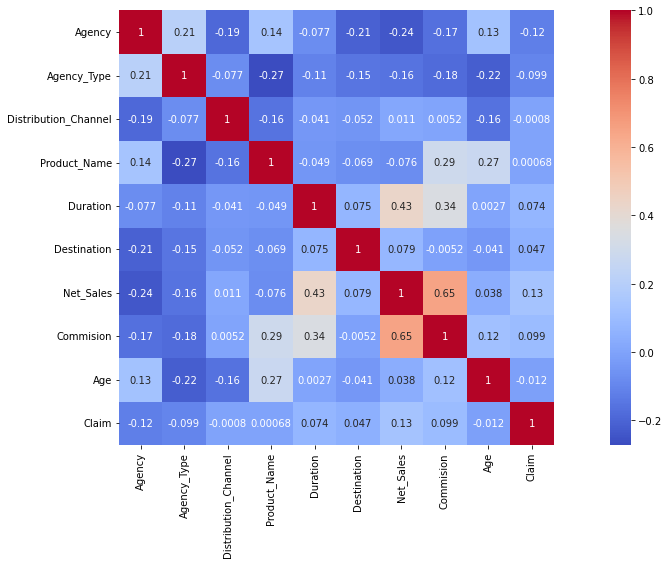

In [36]:
plt.figure(figsize = (20,8))
sns.heatmap(df_travel.corr(), square=True,annot=True,cmap= 'coolwarm')

No significant colinearity is observed.

### Preparing features for training and testing

In [37]:
y=df_travel.iloc[:,[-1]]
X=df_travel.drop(y.columns,axis = 1)

In [38]:
y

,Claim
0,0
1,0
2,0
3,0
4,0
...,...
63321,0
63322,0
63323,0
63324,0


In [39]:
X

,Agency,Agency_Type,Distribution_Channel,Product_Name,Duration,Destination,Net_Sales,Commision,Age
0,3,1,0,12,186,79,-29.0,9.57,81
1,3,1,0,12,186,79,-29.0,9.57,71
2,6,1,1,16,65,4,-49.5,29.70,32
3,6,1,1,16,60,4,-39.6,23.76,32
4,6,1,1,16,79,61,-19.8,11.88,41
...,...,...,...,...,...,...,...,...,...
63321,9,0,1,8,111,63,35.0,12.25,31
63322,9,0,1,8,58,26,40.0,14.00,40
63323,9,0,1,8,2,79,18.0,6.30,57
63324,9,0,1,8,3,145,18.0,6.30,63


### Addressing the inbalance in the data

In [40]:
sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(X, y)
print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after SMOTE: {X_sm.shape}''')
print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100

Shape of X before SMOTE: (63321, 9)
Shape of X after SMOTE: (124788, 9)

Balance of positive and negative classes (%):


Claim
0        50.0
1        50.0
dtype: float64

### Scale features (0 to 1)

In [41]:
X_new=pd.DataFrame()
to_scale = X_sm.columns
mms = MinMaxScaler()
X_new[to_scale] = mms.fit_transform(X_sm[to_scale])
X_new.head()

,Agency,Agency_Type,Distribution_Channel,Product_Name,Duration,Destination,Net_Sales,Commision,Age
0,0.2,1.0,0.0,0.48,0.038107,0.533784,0.300250,0.033757,0.686441
1,0.2,1.0,0.0,0.48,0.038107,0.533784,0.300250,0.033757,0.601695
2,0.4,1.0,1.0,0.64,0.013317,0.027027,0.283153,0.104762,0.271186
3,0.4,1.0,1.0,0.64,0.012293,0.027027,0.291410,0.083810,0.271186
4,0.4,1.0,1.0,0.64,0.016185,0.412162,0.307923,0.041905,0.347458


### Train/Test Split

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_sm, test_size=0.25, random_state=42)

### Train a Random Forest Classifier

This method was used primarily because there isn't strong colinearity between features in the dataset.

In [43]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Since we got the error above, we will change our y to a vector using ravel() as suggested.

In [44]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train.values.ravel())
preds = model.predict(X_test)

### Testing and Accuracy

Accuracy = 0.97
Recall = 0.98



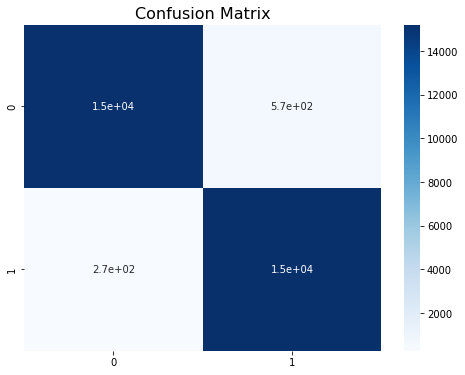

In [45]:
print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

### Final Thoughts

This was a fun, weekend project which allowed me to explore travelers insurance claims data. Although there seems to be high accuracy, I suspect there is overfitting which can be regulated (for Random Forests) by optimizing a tuning parameter which governs the number of features that are randomly chosen to grow each tree from the bootsrapped data. My first approach would be a k-fold cross validation where K is between 5 and 10, I would choose a tuning parameter that minimizes the test sample prediction error. Another possible approach will be growing the size of the random forest, however I would need to tread lightly because Random Forests are generally difficult to overfit.